# Ramp 22 with SDs, Mean abs, Thresholded zero-crossings

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## 0. Helper functions

In [5]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4

    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.015] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    product = product[:, np.newaxis]
    
    #Stack them together
    #all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return product


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd, moving_thres_crossings), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

## 1. Processing data

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-400, -350), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (497500, 18)
X_test's shape:  (197500, 18)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 447750 samples, validate on 49750 samples
Epoch 1/50
447750/447750 [==============================] - 15s 34us/step - loss: 0.0031 - val_loss: 3.8716e-04
Epoch 2/50
447750/447750 [==============================] - 13s 30us/step - loss: 5.7352e-04 - val_loss: 1.5058e-04
Epoch 3/50
447750/447750 [==============================] - 11s 26us/step - loss: 2.4389e-04 - val_loss: 1.0168e-04
Epoch 4/50
447750/447750 [==============================] - 11s 24us/step - loss: 1.7518e-04 - val_loss: 7.2313e-05
Epoch 5/50
447750/447750 [==============================] - 14s 32us/step - loss: 1.3788e-04 - val_loss: 5.4620e-05
Epoch 6/50
447750/447750 [==============================] - 11s 24us/step - loss: 1.1987e-04 - val_loss: 4.8648e-05
Epoch 7/50
447750/447750 [==============================] - 12s 27us/step - loss: 1.0849e-04 - val_loss: 4.4734e-05
Epoch 8/50
447750/447750 [==============================] - 9s 19us/step - loss: 9.6980e-05 - val_loss: 3.8229e-05
Epoch 9/50
447750/447750 [

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

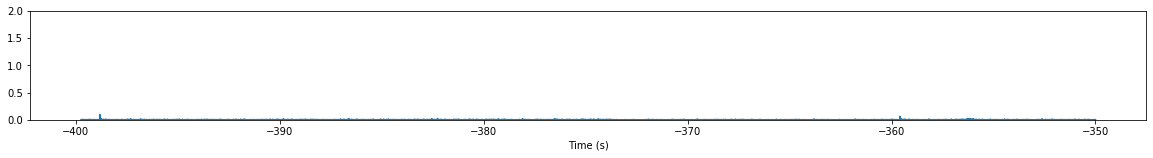

In [9]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

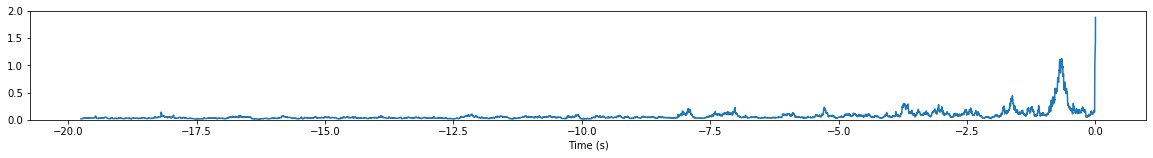

In [11]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 2])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Different training regime (threshold 0.005, 0.1)

In [5]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 18)
X_test's shape:  (197500, 18)


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [7]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [8]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 2s 44us/step - loss: 0.0768 - val_loss: 0.0662
Epoch 2/50
42750/42750 [==============================] - 1s 21us/step - loss: 0.0245 - val_loss: 0.0278
Epoch 3/50
42750/42750 [==============================] - 1s 18us/step - loss: 0.0152 - val_loss: 0.0242
Epoch 4/50
42750/42750 [==============================] - 1s 21us/step - loss: 0.0138 - val_loss: 0.0224
Epoch 5/50
42750/42750 [==============================] - 1s 21us/step - loss: 0.0124 - val_loss: 0.0202
Epoch 6/50
42750/42750 [==============================] - 1s 20us/step - loss: 0.0108 - val_loss: 0.0183
Epoch 7/50
42750/42750 [==============================] - 1s 17us/step - loss: 0.0094 - val_loss: 0.0167
Epoch 8/50
42750/42750 [==============================] - 1s 16us/step - loss: 0.0083 - val_loss: 0.0154
Epoch 9/50
42750/42750 [==============================] - 1s 14us/step - loss: 0.0074 - val_loss: 0.0145
Epoch 

In [9]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [10]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

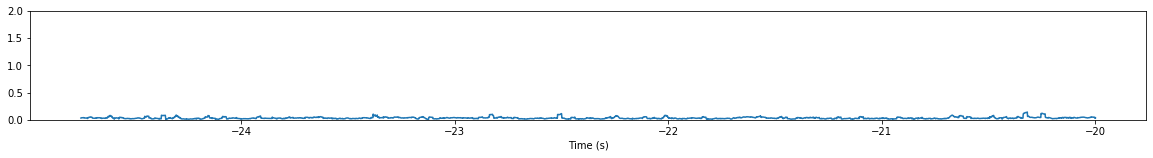

In [11]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

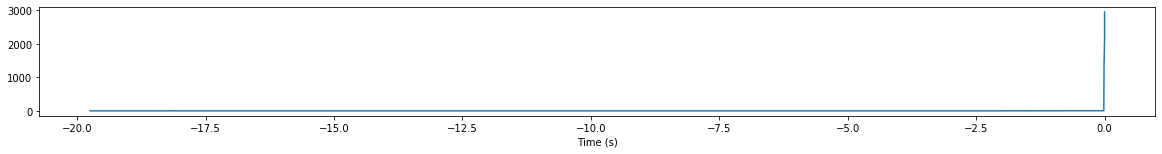

In [60]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
#plt.ylim([0, 5])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Changing threshold range (0.015, 0.1)

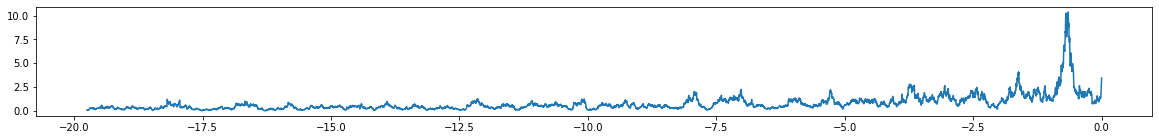

In [31]:
plt.figure(figsize=(20,2))
plt.plot(test_time, X_test[:,17])

(0, 40)

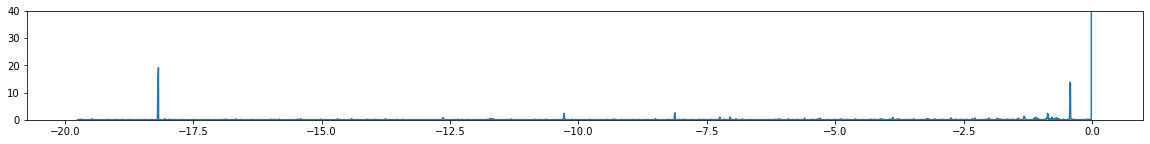

In [63]:
plt.figure(figsize=(20,2))
plt.plot(test_time, X_test[:,5])
plt.ylim([0, 40])

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 18)
X_test's shape:  (197500, 18)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 3s 59us/step - loss: 0.0644 - val_loss: 0.0685
Epoch 2/50
42750/42750 [==============================] - 0s 9us/step - loss: 0.0231 - val_loss: 0.0320
Epoch 3/50
42750/42750 [==============================] - 0s 10us/step - loss: 0.0157 - val_loss: 0.0283
Epoch 4/50
42750/42750 [==============================] - 1s 13us/step - loss: 0.0142 - val_loss: 0.0263
Epoch 5/50
42750/42750 [==============================] - 1s 12us/step - loss: 0.0126 - val_loss: 0.0241
Epoch 6/50
42750/42750 [==============================] - 1s 12us/step - loss: 0.0111 - val_loss: 0.0222
Epoch 7/50
42750/42750 [==============================] - 1s 13us/step - loss: 0.0098 - val_loss: 0.0206
Epoch 8/50
42750/42750 [==============================] - 1s 14us/step - loss: 0.0087 - val_loss: 0.0191
Epoch 9/50
42750/42750 [==============================] - 1s 13us/step - loss: 0.0079 - val_loss: 0.0178
Epoch 1

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

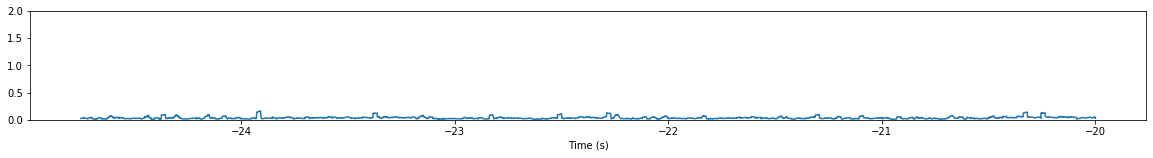

In [9]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

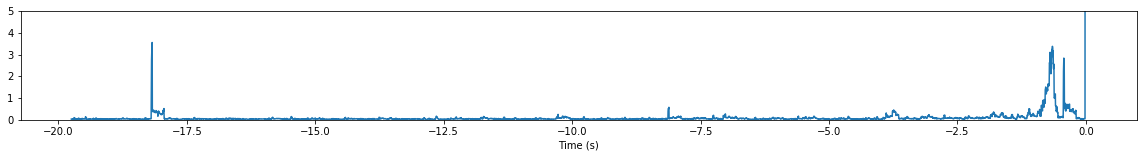

In [11]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 5])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Multiply the product of zero-crossings by 12

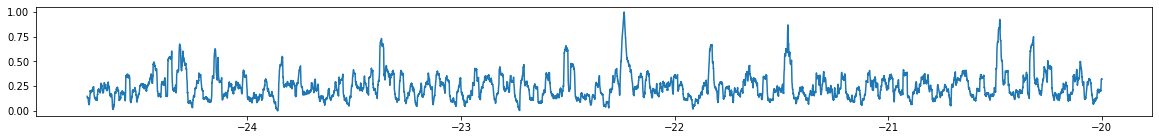

In [42]:
plt.figure(figsize=(20,2))
plt.plot(train_time, X_train[:,4])
#plt.ylim([0, 40])

In [9]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 18)
X_test's shape:  (197500, 18)


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

#Put more importance on the product of zero crossings
X_train[:, 17] *= 12
X_test[:, 17] *= 12

In [11]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [12]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 3s 60us/step - loss: 0.0932 - val_loss: 0.6006
Epoch 2/50
42750/42750 [==============================] - 0s 10us/step - loss: 0.0476 - val_loss: 0.4173
Epoch 3/50
42750/42750 [==============================] - 0s 10us/step - loss: 0.0333 - val_loss: 0.2976
Epoch 4/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0239 - val_loss: 0.1942
Epoch 5/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0168 - val_loss: 0.1369
Epoch 6/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0138 - val_loss: 0.1142
Epoch 7/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0123 - val_loss: 0.1004
Epoch 8/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0112 - val_loss: 0.0903
Epoch 9/50
42750/42750 [==============================] - 0s 7us/step - loss: 0.0103 - val_loss: 0.0822
Epoch 10/50


In [13]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [14]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

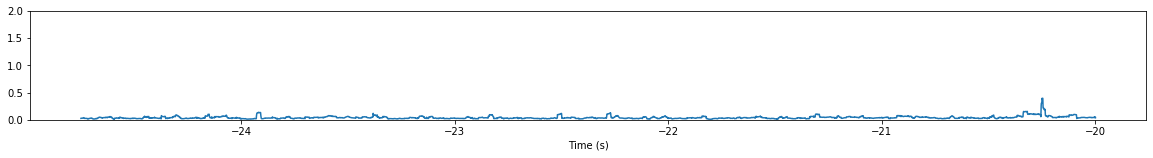

In [15]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

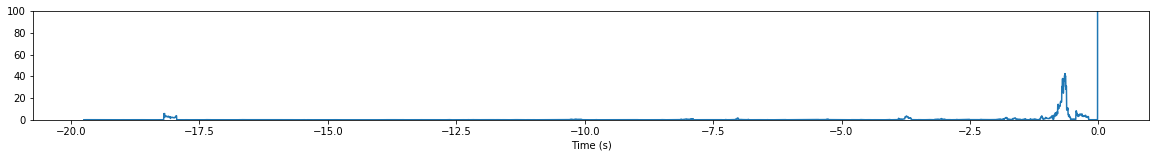

In [36]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 100])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Less inputs

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 13)
X_test's shape:  (197500, 13)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

#Put more importance on the product of zero crossings
#X_train[:, 17] *= 12
#X_test[:, 17] *= 12

In [54]:
# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.1),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6)                 84        
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_18 (Dense)             (None, 13)                91        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 1s 22us/step - loss: 0.8196 - val_loss: 0.7416
Epoch 2/50
42750/42750 [==============================] - 0s 5us/step - loss: 0.6464 - val_loss: 0.5899
Epoch 3/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.5126 - val_loss: 0.4713
Epoch 4/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.4069 - val_loss: 0.3764
Epoch 5/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.3221 - val_loss: 0.2999
Epoch 6/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.2537 - val_loss: 0.2382
Epoch 7/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.1986 - val_loss: 0.1879
Epoch 8/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.1546 - val_loss: 0.1478
Epoch 9/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.1197 - val_loss: 0.1159
Epoch 10/50
42

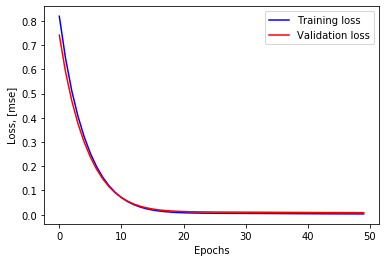

In [56]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [37]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [38]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

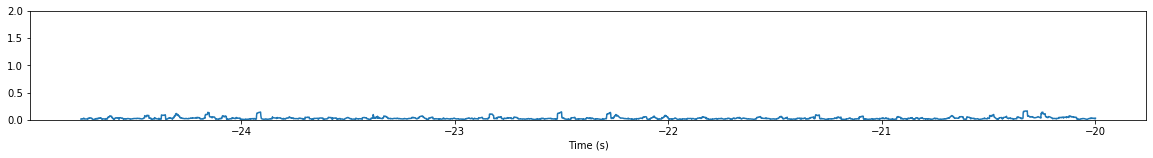

In [39]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

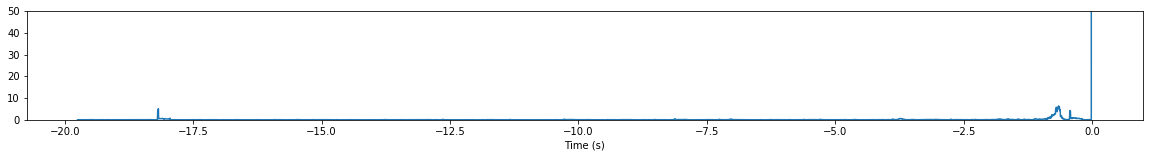

In [40]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])

plt.ylim([0, 50])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Exponential feature for zero-crossings

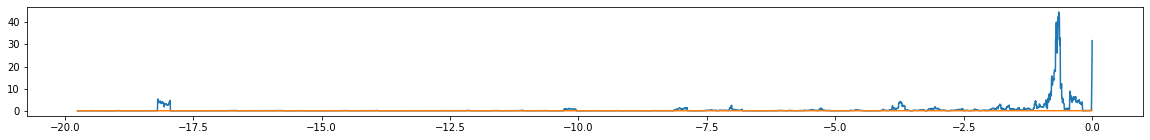

In [16]:
plt.figure(figsize=(20,2))
plt.plot(test_time, X_test[:,12])
plt.plot(test_time, X_pred_test[:,12])
#plt.ylim([0, 40])

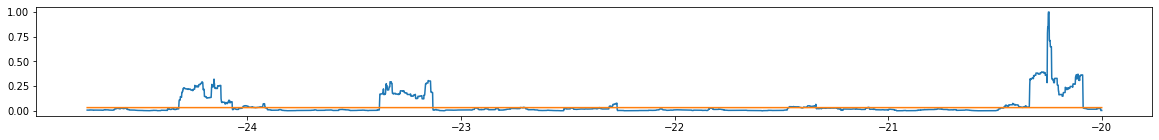

In [17]:
plt.figure(figsize=(20,2))
plt.plot(train_time, X_train[:,12])
plt.plot(train_time, X_pred[:,12])
#plt.ylim([0, 40])

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 13)
X_test's shape:  (197500, 13)


In [4]:
#Put more importance on the product of zero crossings
X_train[:,12] = 10**(X_train[:,12]) 
X_test[:,12] = 10**(X_test[:,12])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l1(0.1),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 13)                91        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 1s 24us/step - loss: 2.1946 - val_loss: 2.0251
Epoch 2/50
42750/42750 [==============================] - 0s 7us/step - loss: 1.8611 - val_loss: 1.7176
Epoch 3/50
42750/42750 [==============================] - 0s 6us/step - loss: 1.5683 - val_loss: 1.4361
Epoch 4/50
42750/42750 [==============================] - 0s 6us/step - loss: 1.2972 - val_loss: 1.1788
Epoch 5/50
42750/42750 [==============================] - 0s 6us/step - loss: 1.0591 - val_loss: 0.9579
Epoch 6/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.8489 - val_loss: 0.7593
Epoch 7/50
42750/42750 [==============================] - 0s 5us/step - loss: 0.6639 - val_loss: 0.5876
Epoch 8/50
42750/42750 [==============================] - 0s 5us/step - loss: 0.5076 - val_loss: 0.4463
Epoch 9/50
42750/42750 [==============================] - 0s 4us/step - loss: 0.3783 - val_loss: 0.3258
Epoch 10/50
42

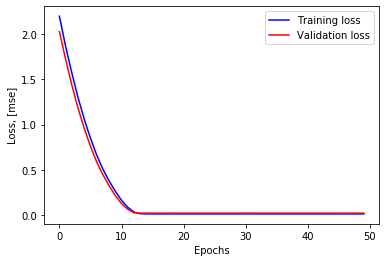

In [7]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [8]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [9]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

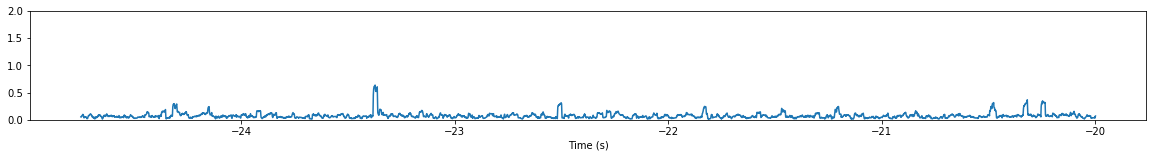

In [10]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

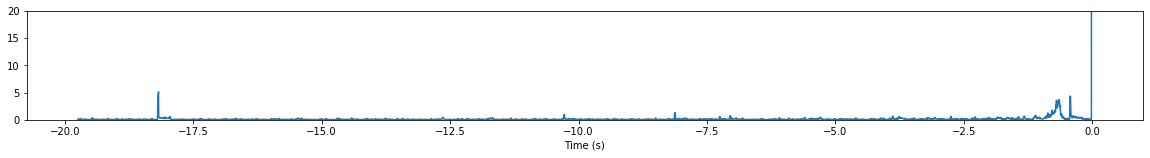

In [13]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])

plt.ylim([0, 20])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

## Make zero-crossings exponentially more important

In [6]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-25, -20), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (47500, 13)
X_test's shape:  (197500, 13)


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

import math
#Put more importance on the product of zero crossings
X_train[:,12] = (1.25)**(X_train[:,12]) 
X_test[:,12] = (1.25)**(X_test[:,12])

In [8]:
# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l1(0.1),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 13)                91        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 42750 samples, validate on 4750 samples
Epoch 1/50
42750/42750 [==============================] - 1s 24us/step - loss: 2.2614 - val_loss: 2.0877
Epoch 2/50
42750/42750 [==============================] - 0s 6us/step - loss: 1.9095 - val_loss: 1.7521
Epoch 3/50
42750/42750 [==============================] - 0s 5us/step - loss: 1.5871 - val_loss: 1.4385
Epoch 4/50
42750/42750 [==============================] - 0s 6us/step - loss: 1.2962 - val_loss: 1.1701
Epoch 5/50
42750/42750 [==============================] - 0s 5us/step - loss: 1.0552 - val_loss: 0.9484
Epoch 6/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.8465 - val_loss: 0.7531
Epoch 7/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.6632 - val_loss: 0.5805
Epoch 8/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.5060 - val_loss: 0.4391
Epoch 9/50
42750/42750 [==============================] - 0s 6us/step - loss: 0.3761 - val_loss: 0.3191
Epoch 10/50
42

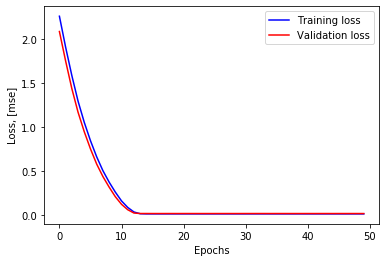

In [10]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [11]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [12]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

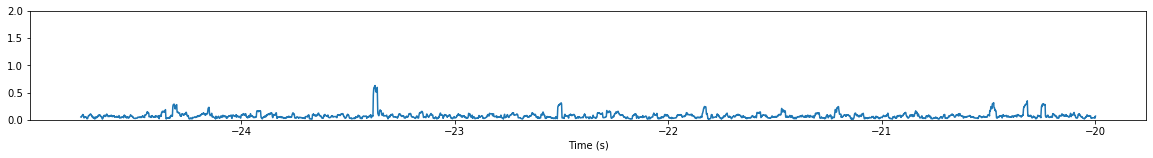

In [13]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

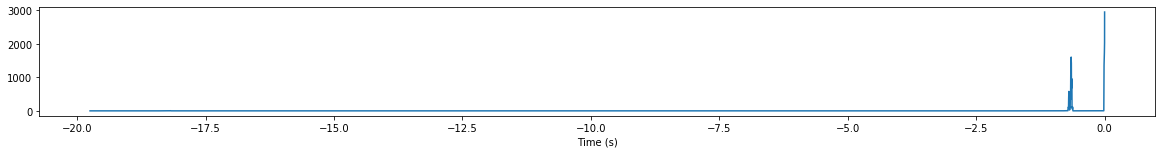

In [14]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])

#plt.ylim([0, 20])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")